In [1]:
import cv2
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
%matplotlib inline  
%autosave 120
try:
    import vrep
except:
    print ('--------------------------------------------------------------')
    print ('"vrep.py" could not be imported. This means very probably that')
    print ('either "vrep.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "vrep.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
from IPython.display import clear_output
from IPython.display import display
import ctypes 

Autosaving every 120 seconds


## load the saved image

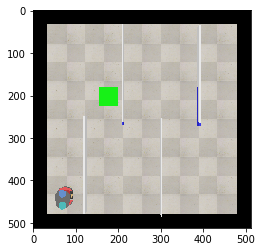

In [2]:
img = cv2.imread("grid_with_orientation.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
%matplotlib inline
plt.imshow(img)
plt.show()

In [13]:
img[200][170]

array([ 23, 241,  23], dtype=uint8)

## Obstacle Grid


In [15]:
def obstacles_grid(img):
    # getting the walls 
    mask_wall = cv2.inRange(img, np.array([230,230,230]),np.array([240,240,240]))
    # getting the rims
    mask_rim = cv2.inRange(img, 0, 0)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)
    return mask_total

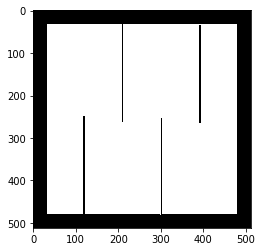

In [16]:
img_obs = obstacles_grid(img)
%matplotlib inline
plt.imshow(img_obs, cmap="gray")
plt.show()

In [25]:
mask_wall = cv2.inRange(img, np.array([230,230,230]),np.array([240,240,240]))
mask_rim = cv2.inRange(img, 0, 0)

In [31]:
mask_rim[100]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

### Robot position and orientation

In [ ]:
def get_front_disk_position (img):
    front_disk_mask = cv2.inRange(img, np.array([100,140,205]), np.array([105,145,210]))
    contours, hierarchy = cv2.findContours(front_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #no need for the for loop but it is used to avoid errors
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])

def get_back_disk_position (img):
    rear_disk_mask = cv2.inRange(img, np.array([75,185,185]), np.array([80,190,190]))   
    contours, hierarchy = cv2.findContours(rear_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #no need for the for loop but it is used to avoid errors
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])

def get_robot_orientation(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    orientation = np.arctan2(rear_disk_position[1]-front_disk_position[1] , rear_disk_position[0]-front_disk_position[0])
    return orientation

In [ ]:
orient = get_robot_orientation(img)
print(orient)

In [ ]:
def get_robot_position(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    robot_pos = (front_disk_position+rear_disk_position)/2
    return tuple(robot_pos.astype('int'))

In [ ]:
center_robot = get_robot_position(img)
print(center_robot)
%matplotlib inline
plt.imshow(img)
plt.plot(center_robot[1],center_robot[0], "*r")
plt.show()

## Goal Position

In [ ]:
def get_goal_position(img):
    goal_mask = cv2.inRange(img[:,:,1], 240, 255)
    goal_mask = cv2.GaussianBlur(goal_mask, (9, 9), 0)
    contours, hierarchy = cv2.findContours(goal_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #no need for the for loop but it is used to avoid errors
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

    return goal_mask, (cY,cX)

In [ ]:
img_goal, center_goal = get_goal_position(img)
print(center_goal)
%matplotlib inline
plt.imshow(img_goal, cmap="gray")
plt.show()

## A* planning


In [ ]:
def search(grid,init,goal,cost, D = 1, fnc='Euclidean', D2 = 1):
    
    def Euclidean_fnc(current_indx, goal_indx,D = 1):
        return np.sqrt( ( (current_indx[0]-goal_indx[0])**2 + (current_indx[1]-goal_indx[1])**2 ) )
    def Manhattan_fnc(current_indx, goal_indx,D = 1):
        dx = np.sqrt((current_indx[0]-goal_indx[0])**2)
        dy = np.sqrt((current_indx[1]-goal_indx[1])**2)
        return D * (dx + dy)
    def Diagonal_fnc(current_indx, goal_indx,D = 1):
        dx = np.sqrt((current_indx[0]-goal_indx[0])**2)
        dy = np.sqrt((current_indx[1]-goal_indx[1])**2)
        return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy) 
    
    if fnc=='Euclidean':
        hueristic_fnc = Euclidean_fnc
    elif fnc == "Manhattan":
        hueristic_fnc = Manhattan_fnc
    elif fnc == "Diagonal" :
        hueristic_fnc = Diagonal_fnc
    
    
    def near_obstacles(point, half_kernel = 5):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(min(point[0] + half_kernel, grid.shape[0]))
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(min(point[1] + half_kernel, grid.shape[1]))
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
    
    def delta_gain(gain = 1):
        delta = np.array([[-1, 0], # go up
                          [-1,-1], # up left
                          [ 0,-1], # go left
                          [ 1,-1], # down left
                          [ 1, 0], # go down
                          [ 1, 1],  # down right
                          [ 0, 1], # go right         
                          [-1, 1] # up right         
         ]) 
        return delta*gain
    
    delta = delta_gain(gain = 5)
    front = PriorityQueue()
    G = 0
    H = hueristic_fnc(init, goal, D)
    F = G+H
    front.put((F, G, init))
    discovered = []
    discovered.append(init)
    
    actions = np.ones_like(grid)*-1
    count = 0
    path = []
    
    def policy_draw(indx):
        indx_old = tuple(indx)
        indx_new = tuple(indx)
        path.append(tuple(goal))
        while indx_new != init:
            indx_new = tuple( np.array(indx_old) - delta[int(actions[indx_old])] )
            path.append(indx_new)
            indx_old = indx_new
    
        
    while not front.empty() :
        front_element = front.get()
        G = front_element[1]
        indx = front_element[2]
        if ((indx[0] >= goal[0]-20) and (indx[0] < goal[0]+20)) and ((indx[1] >= goal[1]-20) and (indx[1] < goal[1]+20)):
            policy_draw(indx)
            print("found goal")
            print(count)
            print(front_element)
            break 
        else:
            for y in range(len(delta)) :
                indx_new = tuple(indx + delta[y])
                if ((np.any(np.array(indx_new) < 0)) or (indx_new[0] > grid.shape[0]-1) or (indx_new[1] > grid.shape[1]-1)) :
                    continue
                if (grid[indx_new] >= 128) and (indx_new not in  discovered) :
                    count += 1
                    # if the obstacle is inside the robot :D, have a really high cost
                    if near_obstacles(indx_new, half_kernel = 35):
                        g_new = G + 1500*cost
                    # if the obstacle is about a robot's length near it , have a high cost
                    elif near_obstacles(indx_new, half_kernel = 70):
                        g_new = G + 15*cost
                    # as before
                    elif near_obstacles(indx_new, half_kernel = 100):
                        g_new = G + 10*cost
                    # as before
                    elif near_obstacles(indx_new, half_kernel = 110):
                        g_new = G + 5*cost
                    else:
                        g_new = G + cost
                    #trying to increase the cost of rapidly changing direction
                    if y == actions[indx]:
                        g_new = g_new 
                    elif (y-1)%len(delta) == actions[indx] or (y+1)%len(delta) == actions[indx]:
                        g_new = g_new + 5*cost
                    else :
                        g_new = g_new + 10*cost
                    h_new = hueristic_fnc(indx_new, goal, D)
                    f_new = (g_new + h_new)-0.0001*count
                    front.put((f_new, g_new, indx_new))
                    discovered.append(indx_new)
                    actions[indx_new] = y        
    else:
        print(count)
        print("fail")                                
    return actions, np.array(path[::-1])

In [ ]:
tick = time.time()
actions, path = search(img_obs,center_robot,center_goal,cost = 1, D = 0.5, fnc='Diagonal')
tock = time.time()
print(tock-tick)

## Path smoothing

In [ ]:
def smooth(path,grid, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001, number_of_iter = 1e3):
    newpath = np.copy(path).astype('float64')
    def get_near_obstacles(point, area = 5):
        x_start = int(max(point[0] - area, 0))
        x_end = int(point[0] + area)
        y_start = int(max(point[1] - area, 0))
        y_end = int(point[1] + area)
        points = np.argwhere(grid[x_start:x_end, y_start:y_end]<128)
        points [:,0] += x_start
        points [:,1] += y_start
        if not points.size:
            points = point.copy()
        return points
    
    def near_obstacles(point, half_kernel = 2):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(point[0] + half_kernel)
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(point[1] + half_kernel)
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
        
    error = np.ones(path.shape[0])*tolerance+tolerance
    num_points = path.shape[0]
    for count in range(int(number_of_iter)):
        for i in range(1,num_points-1):
            old_val = np.copy(newpath[i])
            update1 = weight_data*(path[i] - newpath[i])
            update2 = weight_smooth*(newpath[i-1]+newpath[i+1]-2*newpath[i])
            newpath[i]+=update1+update2 
            if near_obstacles(newpath[i], half_kernel = 35):
                newpath[i] = old_val
            error[i] = np.abs(np.mean(old_val-newpath[i]))
        if np.mean(error) < tolerance:
            break
    print(count)
    return newpath 

In [ ]:
newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.6, number_of_iter = 1000)

## Plotting everything

In [ ]:
%matplotlib inline
fig1 = plt.figure(figsize=(15, 15))  
# plt.imshow(img_obs, cmap="gray")
plt.imshow(img)
plt.plot(path[:,1], path[:,0],'-r')
plt.plot(newpath[:,1], newpath[:,0],'-m')
# plt.plot(yp, xp,'-b')
plt.plot(center_goal[1], center_goal[0], '*b')
plt.plot(center_robot[1], center_robot[0], 'sg')
# plt.plot(newpath[11,1],newpath[11,0], '*r')
plt.show()
fig1.savefig('Astar_smooth_vrep.png', dpi=150)

## Some helping functions

In [ ]:
#transform from image frame to vrep frame
def transform_points_from_image2real (points):
    import pdb;pdb.set_trace();
    if points.ndim < 2:
        flipped = np.flipud(points)
    else:
        flipped = np.fliplr(points)
    scale = 5/445
    points2send = (flipped*-scale) + np.array([2.0555+0.75280899, -2.0500+4.96629213])
    return points2send

In [ ]:
#transform from vrep frame to robot frame
def transform2robot_frame(pos, point, theta):
    import pdb;pdb.set_trace();
    pos = np.asarray(pos)
    point = np.asarray(point)
    T_matrix = np.array([
            [np.sin(theta), np.cos(theta)],
            [np.cos(theta), -1*np.sin(theta)],
            ])
    trans = point-pos
    if trans.ndim >= 2:
        trans = trans.T
        point_t = np.dot(T_matrix, trans).T
    else:
        point_t = np.dot(T_matrix, trans)
    return point_t

In [ ]:
def get_distance(points1, points2):
    return np.sqrt(np.sum(np.square(points1 - points2), axis=1))

In [ ]:
def is_near(robot_center, point, dist_thresh = 0.25):
    dist = np.sqrt((robot_center[0]-point[0])**2 + (robot_center[1]-point[1])**2)
    return dist<=dist_thresh

In [ ]:
class pid():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.error = 0.0
        self.error_old = 0.0
        self.error_sum = 0.0
        self.d_error = self.error - self.error_old
    def control(self,error):
        self.error = error
        self.error_sum += error
        self.d_error = self.error - self.error_old
        P = self.kp*self.error
        I = self.ki*self.error_sum
        D = self.kd*self.d_error
        self.error_old = self.error
        return P+I+D    

In [ ]:
def send_path_4_drawing(path, sleep_time = 0.07):
    #the bigger the sleep time the more accurate the points are placed but you have to be very patient :D
    for i in path:
        point2send = transform_points_from_image2real (i)
        packedData=vrep.simxPackFloats(point2send.flatten())
        raw_bytes = (ctypes.c_ubyte * len(packedData)).from_buffer_copy(packedData)	
        returnCode=vrep.simxWriteStringStream(clientID, "path_coord", raw_bytes, vrep.simx_opmode_oneshot)
        time.sleep(sleep_time)
    

## Robot Model
https://chess.eecs.berkeley.edu/eecs149/documentation/differentialDrive.pdf

In [ ]:
d = 0.331 #wheel axis distance
r_w = 0.09751 #wheel radius

In [ ]:
def pioneer_robot_model(v_des, omega_des):
    v_r = (v_des+d*omega_des)
    v_l = (v_des-d*omega_des)
    omega_right = v_r/r_w
    omega_left = v_l/r_w
    return omega_right, omega_left

## Doing everything live

In [ ]:
lad = 0.5 #look ahead distance
print ('Starting Connection')
vrep.simxFinish(-1) # just in case, close all opened connections
clientID=vrep.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to V-REP
print(clientID)

if clientID!=-1:
    print ('Connected to remote API server')  
    e = vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
    print('start',e)
    try:
        res,camera0_handle = vrep.simxGetObjectHandle(clientID,'top_view_camera',vrep.simx_opmode_oneshot_wait)
        res_l,right_motor_handle = vrep.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',vrep.simx_opmode_oneshot_wait)
        res_r,left_motor_handle = vrep.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',vrep.simx_opmode_oneshot_wait)
        res_las,look_ahead_sphere = vrep.simxGetObjectHandle(clientID,'look_ahead',vrep.simx_opmode_oneshot_wait)
        indx = 0
        err = 10 #to make a knida do while out of while
        theta = 0.0
        dt = 0.0
        count = 0
        om_sp = 0
        d_controller   = pid(kp=0.5, ki=0, kd=0)
        omega_controller = pid(0.5, 0., 0.)
        while err != vrep.simx_return_ok:
            tick = time.time()
            errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
            errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
            err,resolution,image=vrep.simxGetVisionSensorImage(clientID,camera0_handle,0,vrep.simx_opmode_streaming)  
            if err == vrep.simx_return_ok:
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])
                img_obs = obstacles_grid(img)
                center_robot = get_robot_position(img)
                img_goal, center_goal = get_goal_position(img)
                _ , path = search(img_obs,center_robot,center_goal,cost = 1, D = 1 , fnc='Manhattan')
                newpath = smooth(path,img_obs, weight_data = 0.1, weight_smooth = 0.65, number_of_iter = 1000)                
                path_to_track = transform_points_from_image2real(newpath)
                tock = time.time()                
                dt = tock - tick
                print("planning takes : ", dt)
                send_path_4_drawing(newpath, 0.05)
                center_goal = transform_points_from_image2real(np.array(center_goal))
        while not is_near(center_robot, center_goal, dist_thresh = 0.25):            
            tick = time.time()
            err,resolution,image=vrep.simxGetVisionSensorImage(clientID,camera0_handle,0,vrep.simx_opmode_streaming)        
            if err == vrep.simx_return_ok:
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])
                center_robot = get_robot_position(img)
                center_robot = transform_points_from_image2real(np.array(center_robot))
                theta = get_robot_orientation(img)
                theta = np.arctan2(np.sin(theta), np.cos(theta))
                path_transformed = transform2robot_frame(center_robot, path_to_track, theta)
                dist = get_distance(path_transformed, np.array([0,0]))
                #loop to determine which point will be the carrot
                for i in range(dist.argmin(), dist.shape[0]):
                    if dist[i] < lad and indx <= i:
                        indx = i
                #mark the carrot with the sphere
                returnCode=vrep.simxSetObjectPosition(clientID,look_ahead_sphere,-1,(path_to_track[indx,0], path_to_track[indx,1], 0.005),vrep.simx_opmode_oneshot)
                orient_error = np.arctan2(path_transformed[indx,1], path_transformed[indx,0])
                #the controllers 
                v_sp = d_controller.control(dist[indx])                     
                om_sp =omega_controller.control(orient_error)
                vr, vl = pioneer_robot_model(v_sp, om_sp)
                errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, vr, vrep.simx_opmode_oneshot)
                errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,vl, vrep.simx_opmode_oneshot)
                count += 1
                tock = time.time()                
                dt = tock - tick
                print(dt)
        else:
            print("GOAAAAAAALL !!")
            errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
            errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
    finally:
        errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
        errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
        time.sleep(0.1)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        vrep.simxFinish(-1)
